# Data Exploration
This notebook contains several analyses of the dataset and intends to reveal the timeseries' internal structures and characteristics.

In [1]:
# imports
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

### Constants

In [2]:
# path to data set
PATH_CLEANED = 'data/data.pckl'

# use this path for testing purpose (sine function with noise)
#PATH_CLEANED = 'data/sine.pckl'

# frequency
PERIOD = 'W'
# period length
PERIOD_LEN = 53

### Basic Structure

In [3]:
# load dataset
data = pd.read_pickle(PATH_CLEANED)
mean = data['Global_active_power'].resample(PERIOD).mean()
data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [4]:
print('Sample period from {} to {}'.format(data.index.min(), data.index.max()))

Sample period from 2006-12-16 17:24:00 to 2010-11-26 21:02:00


### Basic Visualization

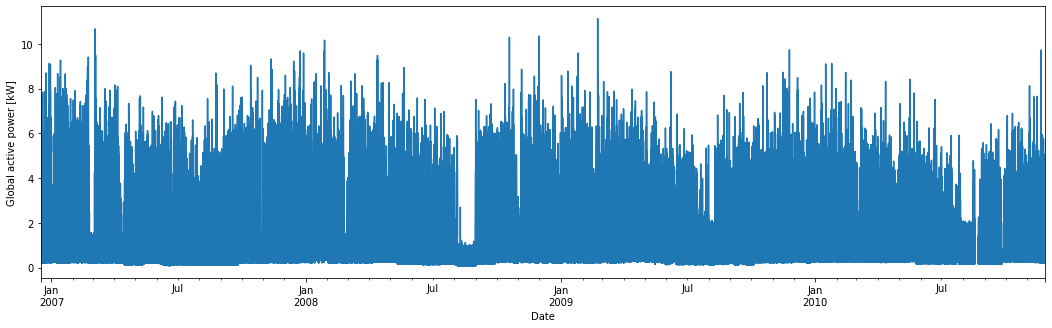

In [5]:
# visualize global active power
ax = data['Global_active_power'].plot(figsize=(18, 5))
ax.set_ylabel('Global active power [kW]')
ax.set_xlabel('Date')
plt.show()

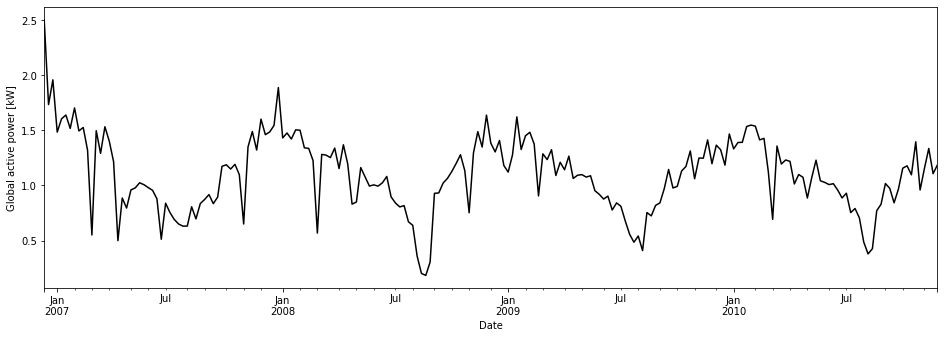

In [6]:
# visualize global active power (averaged over day)
ax = mean.plot(figsize=(13.22, 4.8), c='k')
ax.set_ylabel('Global active power [kW]')
ax.set_xlabel('Date')
plt.tight_layout()
plt.show()

### Autocorrelation, Dickey-Fuller-Test, Ljung-Box-Test, Histogram

Examine the autocorrelation to gain knowledge about the relations within the data. From ACF and PACF, logical interconnections can be observed. When setting ndiff_season > 0, seasonality can be removed.

The Dickey-Fuller-Test allows conlusions about stationarity. Performing the Ljung-Box-Test checks for white noise (especially interesting when seasonal differentiated)

Dickey-Fuller-Test for stationarity checking:
p-value: 0.00046356056515099297


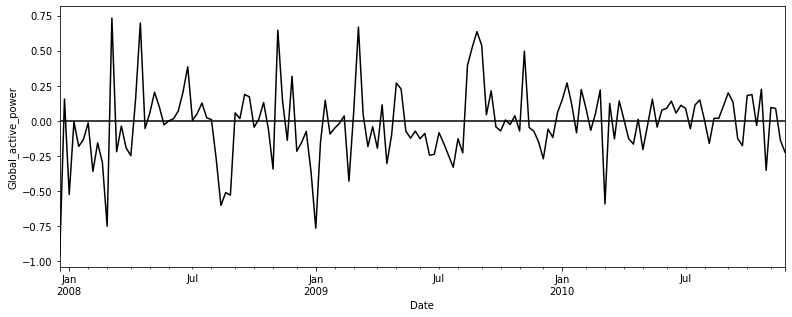

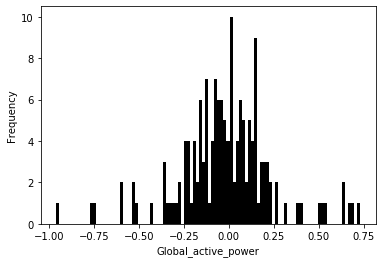

C:\anaconda\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


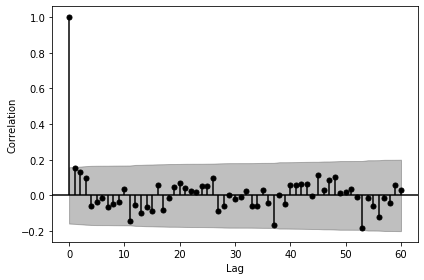

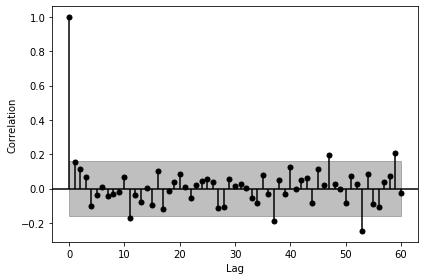

---------------------------------
Perform Ljung-Box-Test to check for white noise:


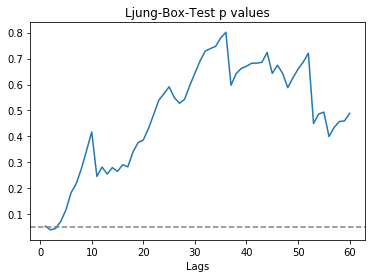

---------------------------------
Statistical Summary:
count    154.000000
mean      -0.019365
std        0.260280
min       -0.960556
25%       -0.148802
50%       -0.017440
75%        0.113957
max        0.731308
Name: Global_active_power, dtype: float64


In [39]:
# visualize ACF and PACF functions
def _plot_corr(ax, acf_x, confint, nlags):
    '''Plots ACF or PACF functions (helper function)
    
    Args:
        ax (plt.axis): Pyplot axis object
        acf_x (np.array): Correlation values
        confint (np.array): Confidence values
        nlags (int): Number of lags
    '''
    lags = np.arange(0, int(nlags) + 1)
    ax.vlines(lags, [0], acf_x)
    ax.axhline(c='k')
    ax.margins(.05)
    ax.plot(lags, acf_x, linewidth=0, marker='o', markersize=5, c='k')
    ax.set_xlabel('Lag')
    ax.set_ylabel('Correlation')
    lags = lags[1:]
    confint = confint[1:]
    acf_x = acf_x[1:]
    lags[0] -= 0.5
    lags[-1] += 0.5
    ax.fill_between(lags, confint[:, 0] - acf_x,
                    confint[:, 1] - acf_x, alpha=.25, color='k')
    
def plot_corr(data, ndiff=0, ndiff_season=0, lags=60):
    '''Displays correlation information
    
    Differentiate data (optional), plots time series, plots histogram, plots ACF and PACF values,
    performs Ljung-Box-Test, displays statistical summary
    
    Args:
        data (pd.Series): Time series values
        ndiff (int): Degree of differencing
        ndiff_seasonal (int): Degree of seasonal differencing
        lags (int): Number of lags to consider
    '''
    # differenciate for stationarity
    if ndiff_season > 0:
        data = data.diff(periods=ndiff_season)
        
    if ndiff > 0:
        data = data.diff(periods=ndiff)
        
    data = data.iloc[(ndiff_season + ndiff):]
        
    # plot new ts
    ax = data.plot(figsize=(13, 4.8), color='k')
    ax.axhline(c='k')
    ax.set_ylabel(data.name)
    ax.set_xlabel('Date')
    plt.show()
    
    # plot histogram
    ax = data.plot(kind='hist', bins=100, color='k')
    ax.set_xlabel(data.name)
    plt.show()
    
    # plot acf
    fig, ax = plt.subplots()
    acf_x, confint = acf(data, nlags=lags, alpha=.05)
    _plot_corr(ax, acf_x, confint, lags)
    plt.tight_layout()
    plt.show()
    
    # pacf
    fig, ax = plt.subplots()
    pacf_x, confint = pacf(data, nlags=lags, alpha=.05)
    _plot_corr(ax, pacf_x, confint, lags)
    plt.tight_layout()
    plt.show()
    
    # perform Ljung-Box-Test
    print('---------------------------------')
    print('Perform Ljung-Box-Test to check for white noise:')
    ax = acorr_ljungbox(data.values, lags, return_df=True)['lb_pvalue'].plot()
    ax.set_title('Ljung-Box-Test p values')
    ax.set_xlabel('Lags')
    plt.axhline(y=0.05, color='k', linestyle='--', c='gray')
    plt.show()
    
    # Summary
    print('---------------------------------')
    print('Statistical Summary:')
    print(data.describe())
    
# Fuller-Dickey-Test
p_value = adfuller(mean)[1]
print('Dickey-Fuller-Test for stationarity checking:')
print('p-value: {}'.format(p_value))

plot_corr(mean, ndiff_season=53, lags=60)

### Missing Values

In [12]:
# calculate nan share
data_bool = data['Global_active_power'].isna()
print('Missing Values: {:.2%}'.format(data_bool.sum()/len(data)))

Missing Values: 1.25%


Maximal length missing values: 7226s


[]

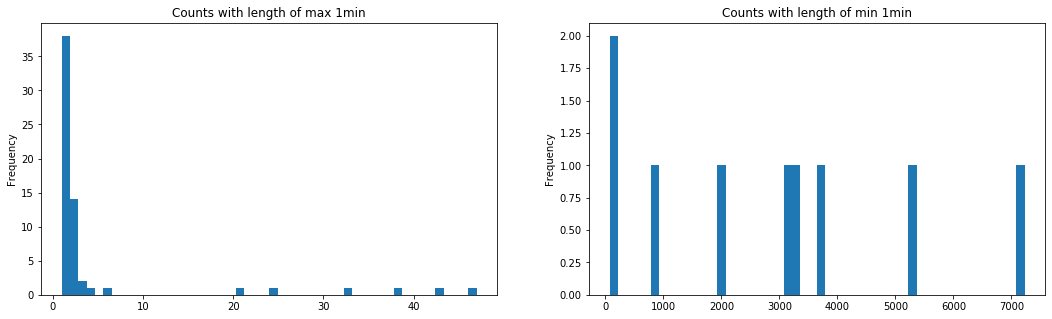

In [13]:
# nan periods statistics
adj_check = (data_bool != data_bool.shift()).cumsum()
nans = adj_check[data_bool == 1].groupby(adj_check[data_bool == 1], sort=False).count()
print('Maximal length missing values: {}s'.format(nans.max()))

fig, axes = plt.subplots(1, 2, figsize=(18, 5))
nans[nans < 61].plot(kind='hist', bins=50, ax=axes[0], title='Counts with length of max 1min')
nans[nans > 60].plot(kind='hist', bins=50, ax=axes[1], title='Counts with length of min 1min')
plt.plot()

The majority of blank periods has a length of less than 5 seconds. However few intervals have a length of up to 7226s, impeding a meaningful interpolation.

### Histogram

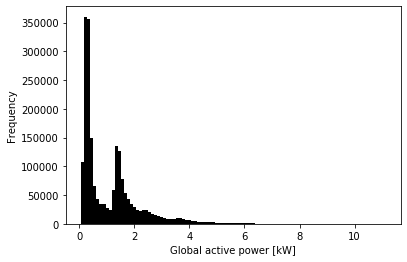

In [14]:
ax = data['Global_active_power'].plot(kind='hist', bins=100, color='k')
ax.set_xlabel('Global active power [kW]')
plt.show()

### Trend Analysis
Decompose time series into trend, seasonal patterns and noise

#### Boxplots for different time periods
Beware that 2006 only has data for a period of less than a month. Thus, mean and distributional parameters might be regarded with caution.

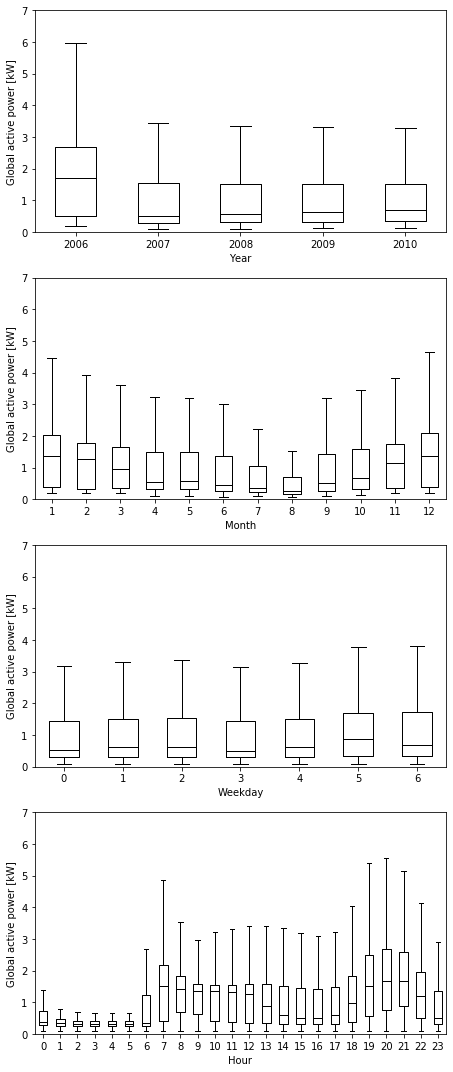

In [16]:
# boxplots for year, month, weekday groups
plots = [(data.index.year, 'Year'), 
         (data.index.month, 'Month'), 
         (data.index.weekday, 'Weekday'), 
         (data.index.hour, 'Hour')
        ]
fig, axes = plt.subplots(len(plots), 1, figsize=(6.4, 15))
plt.setp(axes, ylim=(0, 7))
for idx, plot in enumerate(plots):
    group = pd.DataFrame(data['Global_active_power']).groupby(plot[0])
    group.boxplot(subplots=False, ax=axes[idx], showfliers=False, color='k', grid=False)
    axes[idx].set_xlabel(plot[1])
    axes[idx].set_ylabel("Global active power [kW]")
    axes[idx].set_xticklabels(group.groups.keys())
plt.tight_layout()
plt.show()

#### Trend Analysis on a Weekly Basis

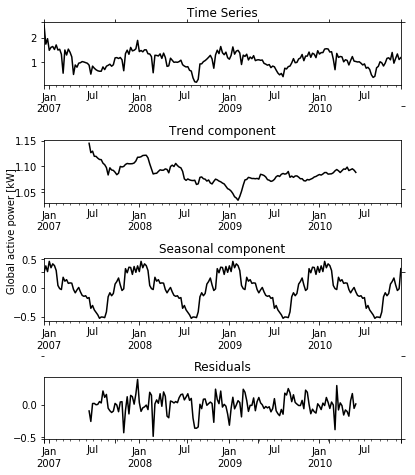

In [17]:
# annual trend
decomp = sm.tsa.seasonal_decompose(data['Global_active_power'].groupby(pd.Grouper(freq=PERIOD)).mean().fillna(method='ffill'), model='additive', period=53)
fig, axes = plt.subplots(4, 1, figsize=(6.4, 7))
for a in axes:
    a.xaxis.label.set_visible(False)
decomp.observed.plot(ax=axes[0], c='k', title='Time Series')
decomp.trend.plot(ax=axes[1], c='k', title='Trend component')
decomp.seasonal.plot(ax=axes[2], c='k', title='Seasonal component')
decomp.resid.plot(ax=axes[3], c='k', title='Residuals')

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)
plt.ylabel("Global active power [kW]")
plt.tight_layout()
plt.show()

### Stationarity
Apply the Dickey-Fuller-Test to test stationarity. Test if time series has a unit root and is thus non-stationary (random walk with drift)

In [24]:
p_value = adfuller(mean)[1]
print('p-value: {}'.format(p_value))

p-value: 0.00046356056515099297


Very low p-value, no unit root existing, thus the ts can be considered stationary

In [18]:
data

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-31,1.901295,0.131386,241.441125,8.029956,1.248636,2.214987,7.409558
2007-01-31,1.546034,0.132676,240.905101,6.546915,1.264237,1.775931,7.383351
2007-02-28,1.401084,0.113637,240.519390,5.914569,1.180217,1.602361,6.703557
2007-03-31,1.318627,0.114747,240.513469,5.572979,1.361343,2.346872,6.504648
2007-04-30,0.891189,0.118778,239.400026,3.825676,1.065886,0.973149,4.800339
2007-05-31,0.985862,0.115343,235.178364,4.297464,1.696617,1.615860,5.139964
2007-06-30,0.826814,0.146395,238.875530,3.603550,1.382673,1.620571,4.375907
2007-07-31,0.667367,0.127481,237.671247,2.944133,0.967265,1.252174,3.478285
2007-08-31,0.764186,0.112816,237.937241,3.312668,0.812475,1.114147,5.052714
